In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
from stable_diffusion_jax import AutoencoderKL, convert_diffusers_to_jax

# convert diffusers checkpoint to jax
pt_path = Path.home() / "models/stable-diffusion-v1-4"
fx_path = Path.home() / "models/stable-diffusion-v1-4-jax"

# convert_diffusers_to_jax(pt_path, fx_path)

/home/ttj/miniconda3/envs/arts/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
# inference with jax
# E dtype = jnp.bfloat16
dtype = None
vae, vae_params = AutoencoderKL.from_pretrained(
    f"{fx_path}/vae", _do_init=False, dtype=dtype
)

2022-09-11 14:58:18.980650: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:190] unable to create StreamExecutor for CUDA:1: failed initializing StreamExecutor for CUDA device ordinal 1: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25444548608


In [3]:
# to use this model, you need to accept the license at https://huggingface.co/ttj/stable-diffusion-vae-anime
vae_anime_path = "ttj/stable-diffusion-vae-anime"
vae, vae_params2 = AutoencoderKL.from_pretrained(
    vae_anime_path, _do_init=False, dtype=dtype, use_auth_token=True
)

In [4]:
import io

import numpy as np
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
from vqgan_jax.modeling_flax_vqgan import VQModel


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))


def top_left_crop(image):
    size = image.size
    min_size = min(size)
    return image.crop((0, 0, min_size, min_size))


def pil_to_np(img, size=(256, 256)):
    img = top_left_crop(img).convert("RGB")
    img = TF.resize(img, size)
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()


def jnp_to_pil(decoded_images):
    decoded_images = decoded_images.clip(0.0, 1.0)  # .reshape((-1, 256, 256, 3))
    return [
        Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        for decoded_img in decoded_images
    ]


@jax.jit
def reconstruct(params_with_encoder, params_with_decoder, original, train=False):
    distribution = vae.encode(original, params=params_with_encoder)
    latent = distribution.mode()
    reconstruction = vae.decode(latent, params_with_decoder, train=train)
    return reconstruction


#

In [5]:
# to gpu
vae_params = jax.device_put(vae_params, jax.devices()[0])
vae_params2 = jax.device_put(vae_params2, jax.devices()[0])

In [6]:
url = "https://m.media-amazon.com/images/I/71NPmBOdq7L._AC_SL1333_.jpg"
original_image = download_image(url)
print(original_image.size)
size = 512
image = pil_to_np(original_image, (size, size))
image = jax.device_put(image, jax.devices()[0])
image1 = image

(900, 1333)


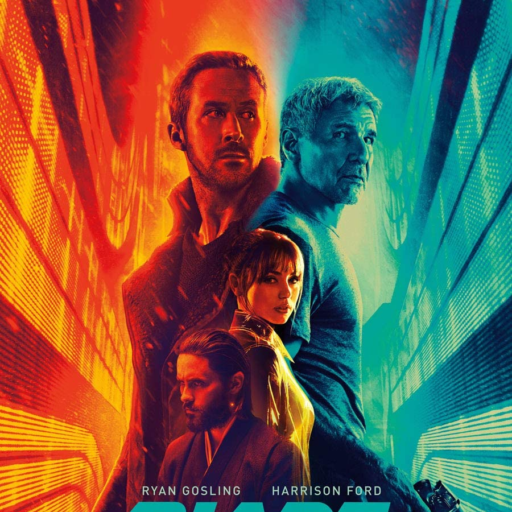

In [7]:
jnp_to_pil(image)[0]

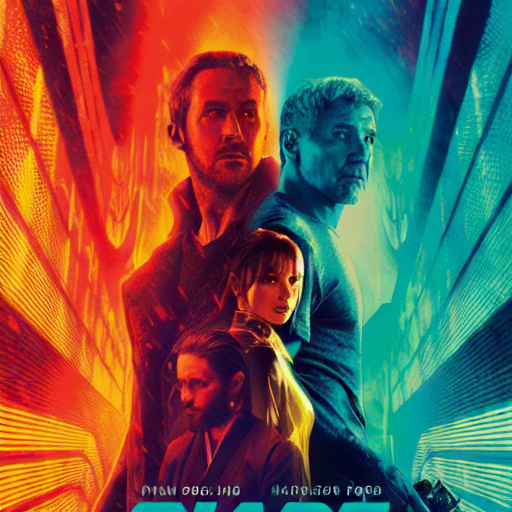

In [8]:
reconstruction = reconstruct(vae_params, vae_params, image)
jnp_to_pil(reconstruction)[0]

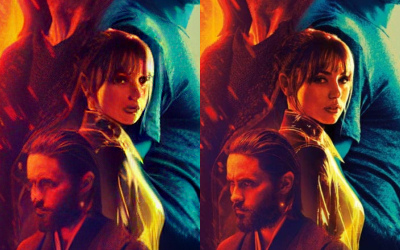

In [9]:
# notice the reconstruction on the smaller faces are noticablely different
a = (reconstruction[:, 200:450, 150:350, :])
b = (image[:, 200:450, 150:350, :])
c = jnp.concatenate([a, b], axis=2)
jnp_to_pil(c)[0]

## VAE finetuned at 256x256

In [10]:
url = "https://m.media-amazon.com/images/M/MV5BNGYyNmI3M2YtNzYzZS00OTViLTkxYjAtZDIyZmE1Y2U1ZmQ2XkEyXkFqcGdeQXVyMTA4NjE0NjEy._V1_.jpg"
original_image = download_image(url)
print(original_image.size)
size = 768 # because the face is smaller in this image, we need to increase the size to get a good reconstruction
image = pil_to_np(original_image, (size, size))
image = jax.device_put(image, jax.devices()[0])

(1132, 1600)


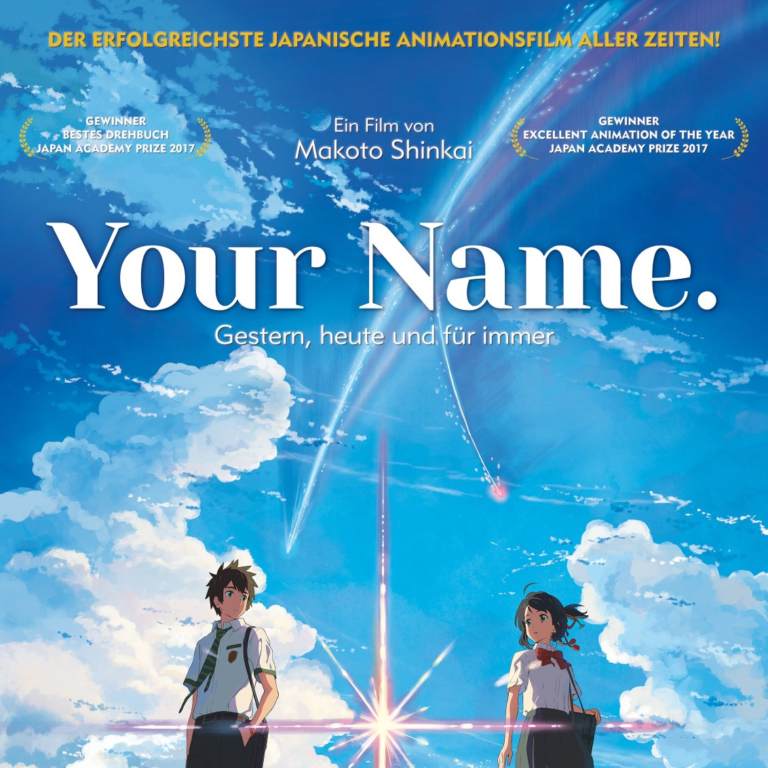

In [11]:
jnp_to_pil(image)[0]

## Original VAE

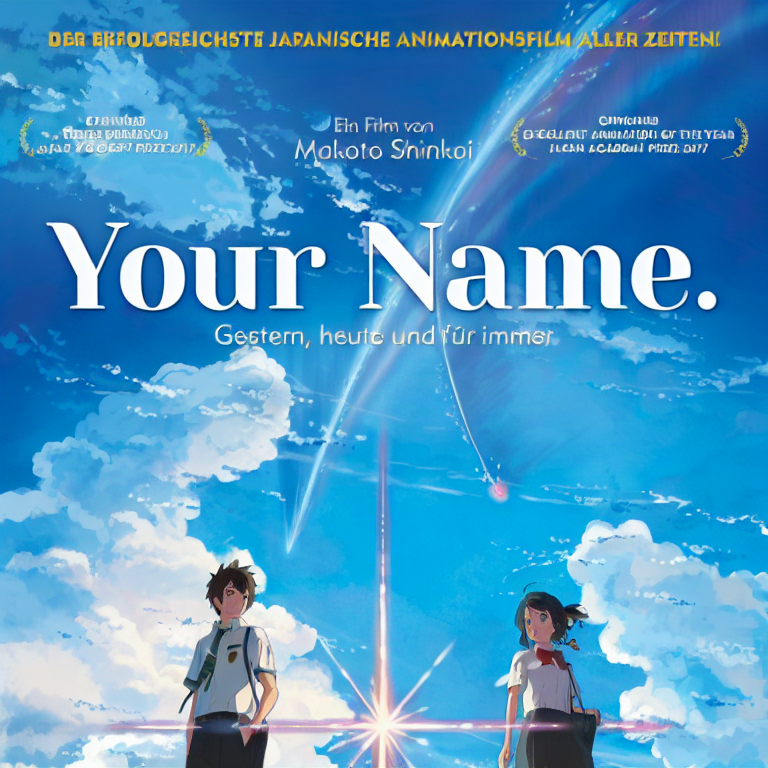

In [12]:
# original
reconstruction = reconstruct(vae_params, vae_params, image)
jnp_to_pil(reconstruction)[0]

## Anime fine-tuned VAE

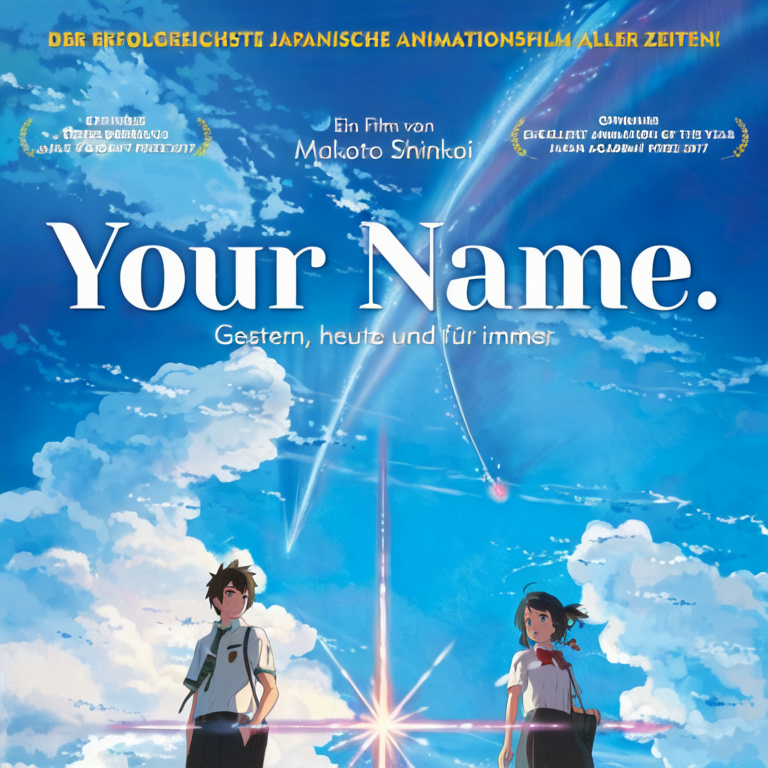

In [13]:
reconstruction = reconstruct(vae_params2, vae_params2, image)
jnp_to_pil(reconstruction)[0]

## Anime VAE can reconstruct non-anime images, sometimes even better than the original VAE

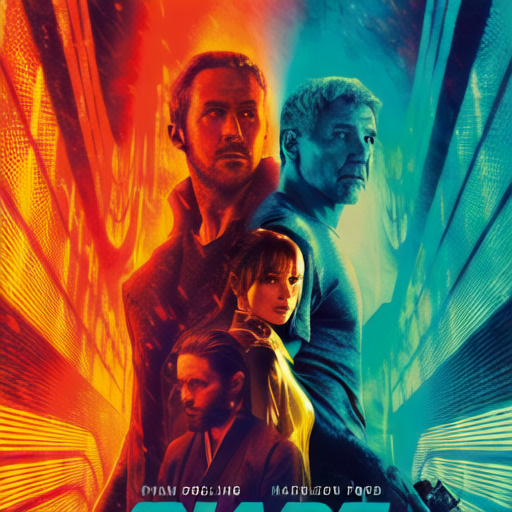

In [14]:
reconstruction = reconstruct(vae_params2, vae_params2, image1)
jnp_to_pil(reconstruction)[0]

left: reconstruction by vae, mid: original, right: reconstruction by vae-anime


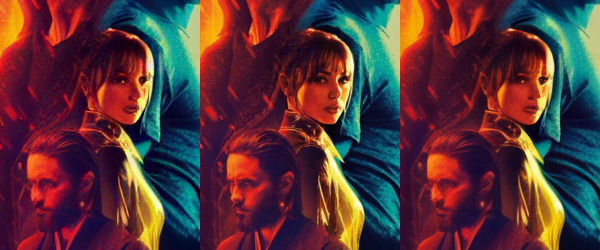

In [15]:
print('left: reconstruction by vae, mid: original, right: reconstruction by vae-anime')
d = (reconstruction[:, 200:450, 150:350, :])
e = jnp.concatenate((c, d), axis=2)
jnp_to_pil(e)[0]

In [16]:
from optax import l2_loss

# a: reconstructed imag
# b: original
# d: reconstructed with anime model

# the l2 loss is lower with the vae-anime
print(f'l2 loss:\nvae: {l2_loss(a, b).mean()}, vae-anime: {l2_loss(d, b).mean()}')

l2 loss:
vae: 0.0016783281462267041, vae-anime: 0.0013527325354516506
